# Importing Kaggle Dataset, Data Loader, Exploratory Data Analysis (EDA)

## Set Up

In [1]:
import os
import json 
from pathlib import Path
from PIL import Image
import random
import shutil
import kagglehub
from kagglehub import KaggleDatasetAdapter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from collections import Counter

import pandas as pd
from collections import defaultdict

import shutil
from tqdm import tqdm

/Users/hannazelis/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download and Move the latest version of the "Pexels 110k 512p JPEG" Dataset

Dataset Link: https://www.kaggle.com/datasets/innominate817/pexels-110k-512p-min-jpg

In [2]:
#download latest version
downloaded_path = kagglehub.dataset_download("innominate817/pexels-110k-512p-min-jpg")
print("Path to dataset files:", downloaded_path)

#path to move downloaded dataset to
destination_path = './data'
os.makedirs(destination_path, exist_ok=True)

#move all files and folders inside the final version path
items = os.listdir(downloaded_path)
if items:
    for item in items:
        source = os.path.join(downloaded_path, item)
        destination = os.path.join(destination_path, item)
        if not os.path.exists(destination):
            shutil.move(source, destination)
            print(f"Moved: {item}")
        else:
            print(f"Skipping existing: {item}")
    
else:
    print("No files to mvoe inside the latest version folder")


Path to dataset files: /Users/hannazelis/.cache/kagglehub/datasets/innominate817/pexels-110k-512p-min-jpg/versions/4
No files to mvoe inside the latest version folder


## Dataset Loader
* Write the paths to all parts of the dataset (images, attributes, prompts, and tags)
    * Load image names
    * Read in attributes
    * Captions
    * Tags into memory

In [3]:
'''
Set up all of the paths to all of the different components of the dataset from Kaggle

pwd: ./data/pexels-110k-512p-min-jpg/
      | --> images/
      | --> attributes_df.json
      | --> pexels-prompts-pairs.json
      | --> tags.txt

Dataset structure and content:
pexels-110k-512p-min-jpg/
      | --> images/
        * 110k images in .jpg format
      | --> attributes_df.json
        * 110k images with their attributes
        * INSERT COLUMN NAMES HERE!!!!!!!!!!!!!!!!!
      | --> pexels-prompts-pairs.json
        * INSERT CONTEXT HERE!!!!!!!!!!!!!!!!!!!!!!
      | --> tags.txt
        * tag names for the 110k images
'''

#all of the paths to different parts of the data
images_path = './data/pexels-110k-512p-min-jpg/images'
attributes_path = './data/pexels-110k-512p-min-jpg/attributes_df.json'
prompts_path = './data/pexels-110k-512p-min-jpg/pexels-prompts-pairs.json'
tags_path = './data/pexels-110k-512p-min-jpg/tags.txt'



#load images
image_filenames = [f for f in os.listdir(images_path) if f.endswith('.jpg')]
print(f"Total images: {len(image_filenames)}")



#load prompt data
with open(prompts_path, 'r') as f:
    prompts_data = json.load(f)



#load attributes data
with open(attributes_path, 'r') as f:
    attributes_data = json.load(f)



#load tags data
with open(tags_path, 'r') as f:
    tags_data = f.read().splitlines()
print(f"Total tags: {len(tags_data)}")



#build up a dictionary for the prompts, connecting the image_id to the caption
imageid_to_caption = {}
for item in prompts_data:
    for img_id, caption in item.items():
        imageid_to_caption[img_id] = caption



#import image attributes data
attributes = pd.read_json(attributes_path)

#print the number of entries in the attributes data
print(f"Number of entries: {len(attributes)}")

#print the first few rows of the dataframe
attributes.head().transpose()

Total images: 109971
Total tags: 21242
Number of entries: 109971


3186010  \
title                        Pink and White Ice Cream Neon Signage   
aspect_ratio                                              0.749809   
main_color                                           [128, 38, 77]   
colors           [#000000, #a52a2a, #bc8f8f, #c71585, #d02090, ...   
tags             [bright, chocolate, close-up, cold, cream, cre...   
adult                                                very_unlikely   
aperture                                                       1.8   
camera                                                    iPhone X   
focal_length                                                   4.0   
google_place_id                        ChIJkUjxJ7it1y0R4qOVTbWHlR4   
iso                                                           40.0   
latitude                                                 -7.746914   
longitude                                               113.226906   
manufacturer                                                 Apple   
medical                                              very_unlikely   
orientation                                                    0.0   
racy                                                      unlikely   
shutter_speed                                                        
software                                                    13.1.3   
spoof                                                very_unlikely   
violence                                             very_unlikely   
location                 Kecamatan Mayangan, Jawa Timur, Indonesia   

                                                           3185509  \
title                         Garnishing of Syrup on a Cheesecake    
aspect_ratio                                                   1.0   
main_color                                         [185, 167, 164]   
colors               [#000000, #696969, #bc8f8f, #cd5c5c, #d3d3d3]   
tags             [cheesecake, dessert, epicure, food photograph...   
adult                                                very_unlikely   
aperture                                                       NaN   
camera                                                               
focal_length                                                   NaN   
google_place_id                                               None   
iso                                                            NaN   
latitude                                                       NaN   
longitude                                                      NaN   
manufacturer                                                         
medical                                              very_unlikely   
orientation                                                    NaN   
racy                                                      unlikely   
shutter_speed                                                        
software                                                             
spoof                                                very_unlikely   
violence                                             very_unlikely   
location                                                      None   

                                                           3182800  \
title                             People in Front of the Computers   
aspect_ratio                                              1.498501   
main_color                                         [176, 175, 169]   
colors               [#000000, #696969, #a9a9a9, #add8e6, #f5f5f5]   
tags             [colleagues, computer, connection, cooperation...   
adult                                                     unlikely   
aperture                                                       NaN   
camera                                                        None   
focal_length                                                   NaN   
google_place_id                                               None   
iso                                                            NaN 

## Put this table into an image for the README.md

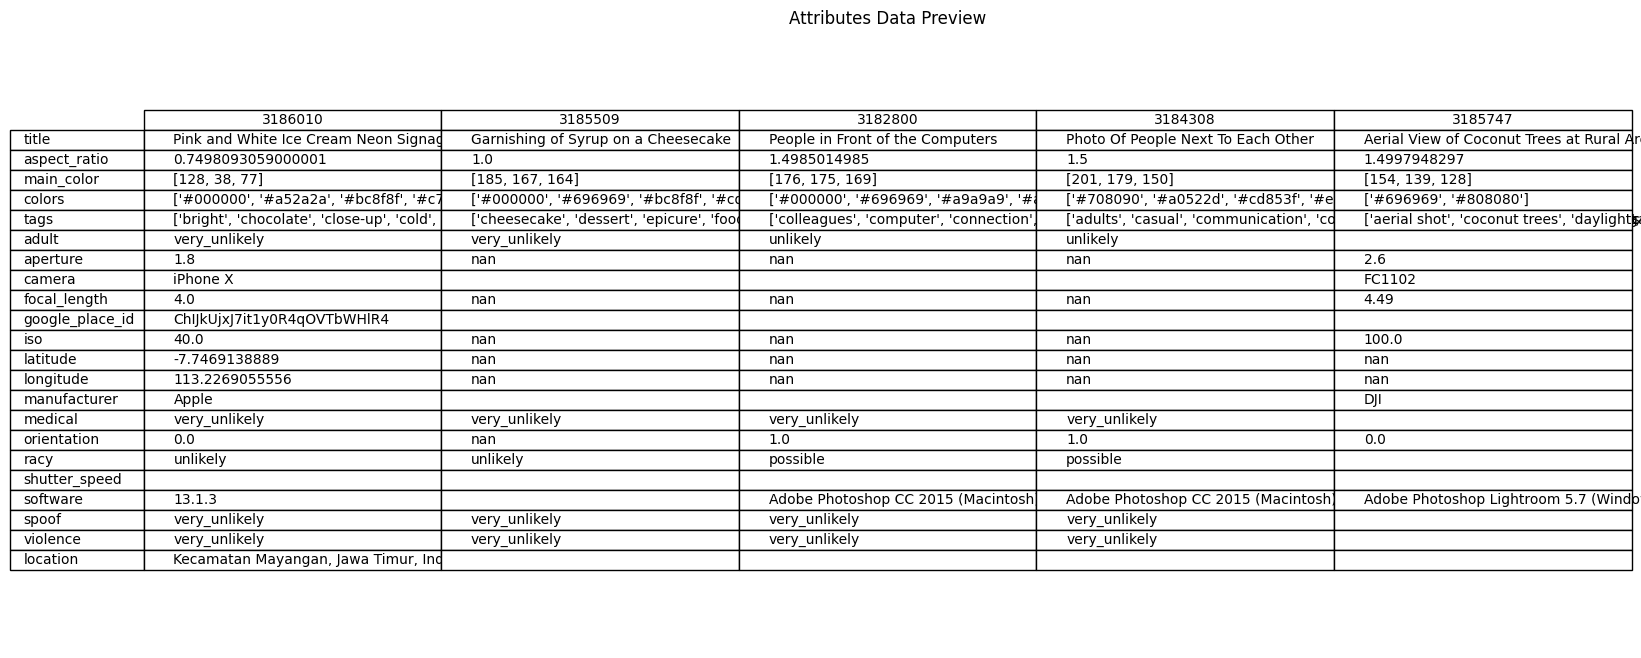

In [4]:
#transpose first 5 rows for a column-wise view
df_preview = attributes.head().transpose()

#plot as a table using matplotlib
fig, ax = plt.subplots(figsize=(16, 8))
plt.title('Attributes Data Preview') 
ax.axis('off') 
table = ax.table(cellText=df_preview.values,
                 colLabels=df_preview.columns,
                 rowLabels=df_preview.index,
                 loc='center',
                 cellLoc='left')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

#save to file
plt.savefig('outputs/eda/attributes_preview.png', bbox_inches='tight')
plt.show()


## Exploratory Data Analysis (EDA)

* Visualize random images
* Image size stats



Image: 159414.jpg
Image ID: 159414
Caption: Orange Petal Flowers With Purple Grass during Daytime
Image Size: (768, 512)


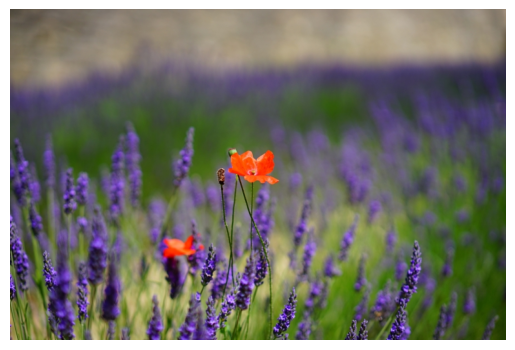



Image: art-artistic-artsy-2832411.jpg
Image ID: art-artistic-artsy-2832411
Caption: No caption found
Image Size: (768, 512)


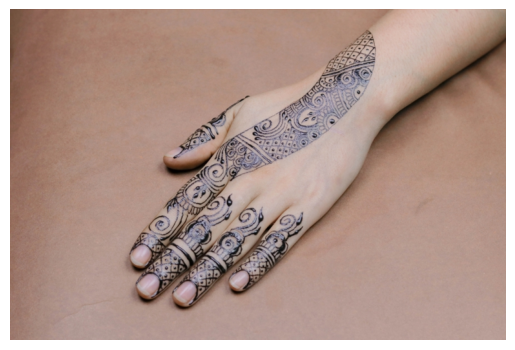



Image: architecture-buildings-city-1687095.jpg
Image ID: architecture-buildings-city-1687095
Caption: No caption found
Image Size: (768, 512)


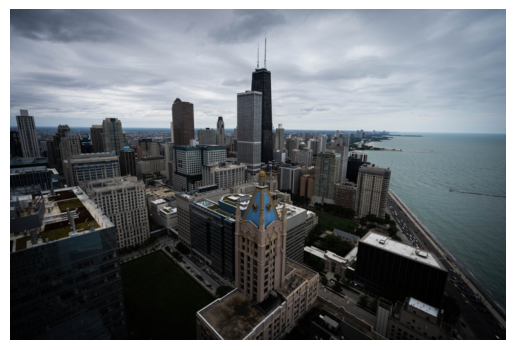



Image: baked-beverage-breakfast-2377476.jpg
Image ID: baked-beverage-breakfast-2377476
Caption: No caption found
Image Size: (512, 768)


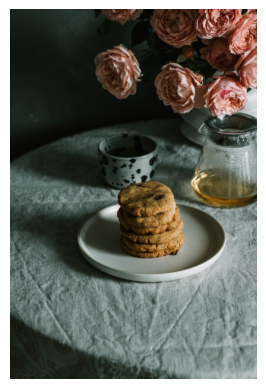



Image: female-girl-person-1561341.jpg
Image ID: female-girl-person-1561341
Caption: No caption found
Image Size: (512, 736)


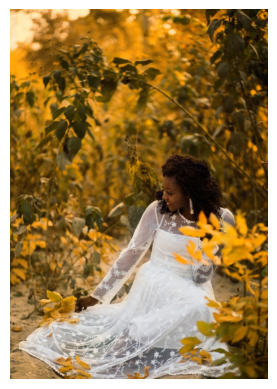

In [5]:
#look at random samples of images from the dataset
sample_images = random.sample(image_filenames, 5)

for img_file in sample_images:
    img_path = os.path.join(images_path, img_file)
    img = Image.open(img_path)
    #get image id and filename
    img_id = img_file.split('.')[0]

    #look up caption
    caption = imageid_to_caption.get(img_id, "No caption found")

    print("\n")
    print(f"Image: {img_file}")
    print(f"Image ID: {img_id}")
    print(f"Caption: {caption}")
    print(f"Image Size: {img.size}")
    plt.imshow(img)
    plt.axis('off')
    #save output data
    plt.savefig(f"outputs/eda/example_images_{img_file}.png", bbox_inches="tight")
    plt.show()

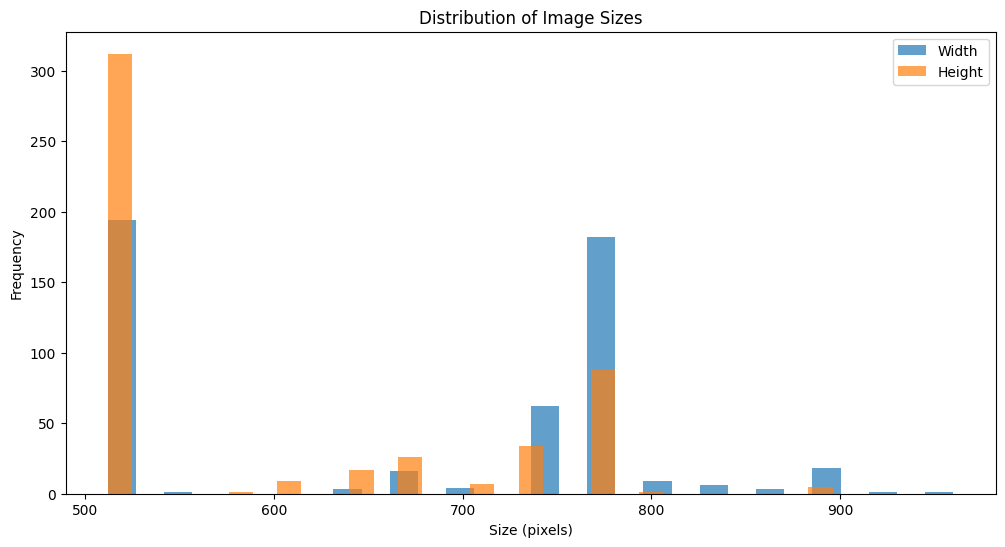

In [6]:
'''
EDA Plot: Distribution of Image Sizes
'''

#check the image sizes via plotting the distribution of the image sizes
sizes = []
for img_file in random.sample(image_filenames, 500):
    img_path = os.path.join(images_path, img_file)
    img = Image.open(img_path)
    sizes.append(img.size)

widths, heights = zip(*sizes)
plt.figure(figsize=(12, 6))
plt.hist(widths, bins=30, alpha=0.7, label='Width')
plt.hist(heights, bins=30, alpha=0.7, label='Height')
plt.legend()
plt.xlabel('Size (pixels)')
plt.ylabel('Frequency')
plt.title('Distribution of Image Sizes')

#save output data
plt.savefig("outputs/eda/distribution_of_image_sizes.png", bbox_inches="tight")

plt.show()

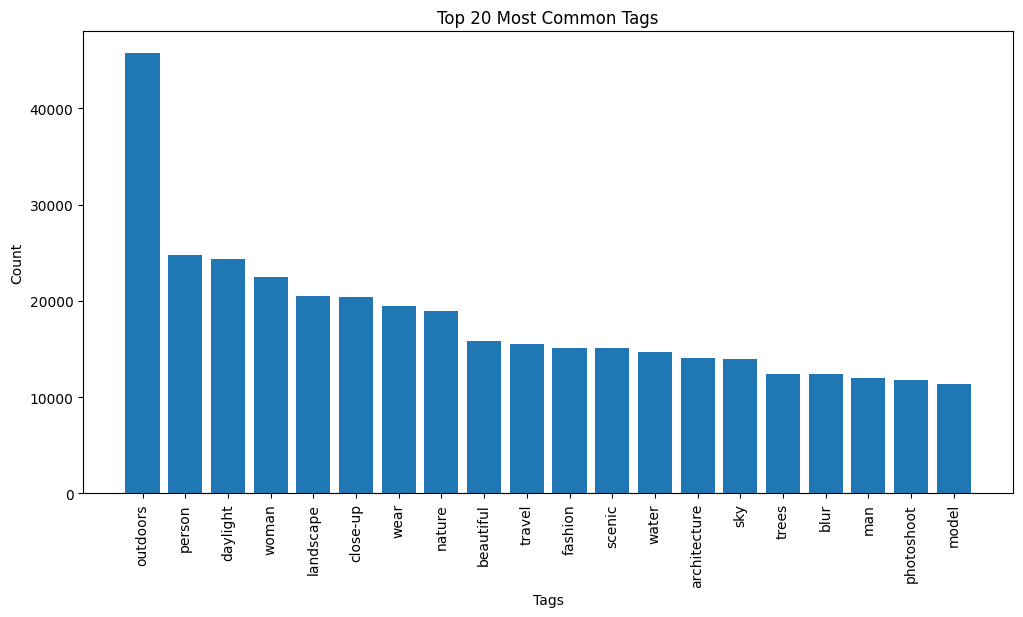

In [7]:
'''
EDA Plot: Top 20 Most Common Tags
'''

all_tags_data = []

for tags_list in attributes['tags'].dropna():
    all_tags_data.extend(tags_list)

tag_counts = Counter(all_tags_data)

#get the top 20 tags
most_common_tags = tag_counts.most_common(20)

tags, counts = zip(*most_common_tags)

plt.figure(figsize=(12, 6))
plt.bar(tags, counts)
plt.xticks(rotation=90)
plt.title('Top 20 Most Common Tags')
plt.xlabel('Tags')
plt.ylabel('Count')
#save output data
plt.savefig("outputs/eda/top_20_most_common_tags.png", bbox_inches="tight")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/hannazelis/Northwestern/spring2025/genAI/imageGenerationProject/aesthetic_moodboard_generation/outputs/eda/dominant_colors_image_./data/pexels-110k-512p-min-jpg/images/702936.jpg.png'

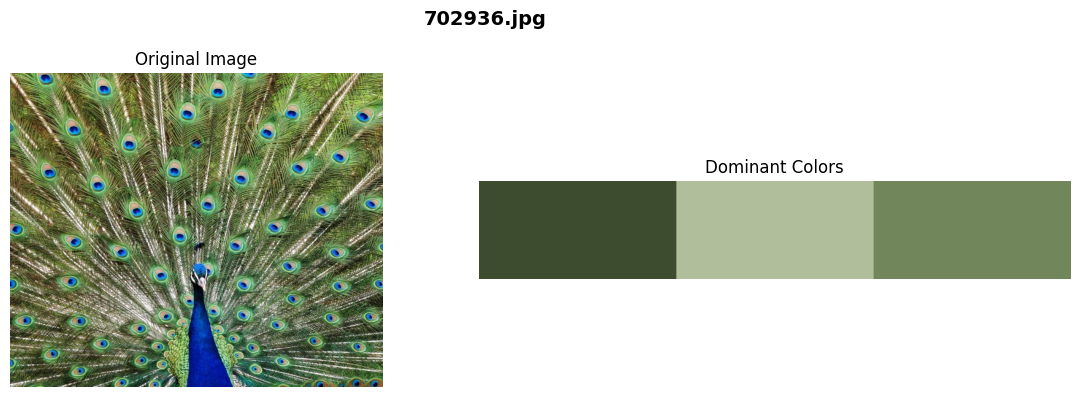

In [11]:
'''
EDA Plot: Dominant Colors in Random Images
'''

def get_main_color(img_path, k=3):
    #read the image from the path
    img = cv2.imread(img_path)

    #convert the image color space from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #reshape the image to a 2D array of pizels (rows = pixels, columns = RGB)
    img = img.reshape((-1, 3))

    #apply KMeans clustering to group pixels into k color clusters
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(img)

    #obtain cluster centers (dominant colors)
    colors = kmeans.cluster_centers_.astype(int)

    #return the dominant colors
    return colors



#implement the function to get the dominant colors for 25 random images
for filename in random.sample(image_filenames, 5):
    img_path = os.path.join(images_path, filename)

    #get dominant colors from the image
    colors = get_main_color(img_path)

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    #show original image
    img =Image.open(img_path)
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[0].set_title('Original Image')

    #create an image filled with dominant colors stacked horizontally
    color_palette = np.zeros((50, 300, 3), dtype=np.uint8)

    step = color_palette.shape[1] // len(colors)
    for i, color in enumerate(colors):
        color_palette[:, i * step:(i + 1) * step] = color

    axs[1].imshow(color_palette)
    axs[1].axis('off')
    axs[1].set_title('Dominant Colors')

    #setup overall title
    fig.suptitle(filename, fontsize=14, fontweight='bold')

    plt.tight_layout()
    #save output data
    save_path=f"outputs/eda/dominant_colors_image_{img_path}.png"
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()


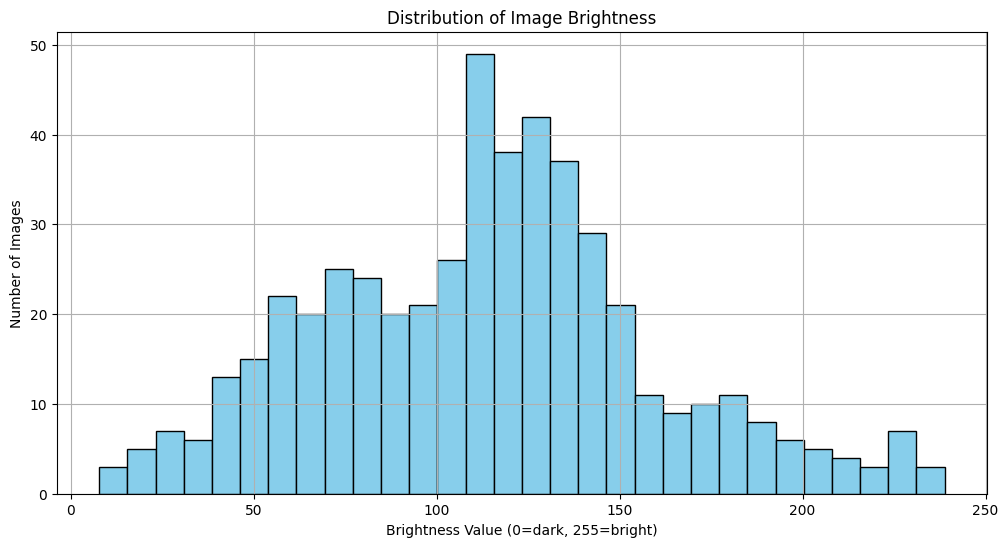

In [12]:
'''
EDA Plot: Brightness / Darknesss Histogram
'''
#store brightness values
brightness_values = []

#calculate brightness fora random sample of images
for filename in random.sample(image_filenames, 500):
    img_path = os.path.join(images_path, filename)
    #read the image
    img = cv2.imread(img_path)
    #convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #take average pixel intensity
    brightness = np.mean(gray)
    #append to the brightness values list
    brightness_values.append(brightness)



#plot the histogram of brightness values
plt.figure(figsize=(12, 6))
plt.hist(brightness_values, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Image Brightness")
plt.xlabel("Brightness Value (0=dark, 255=bright)")
plt.ylabel("Number of Images")
plt.grid(True)
#save output data
plt.savefig("outputs/eda/distribution_of_image_brightness.png", bbox_inches="tight")
plt.show()

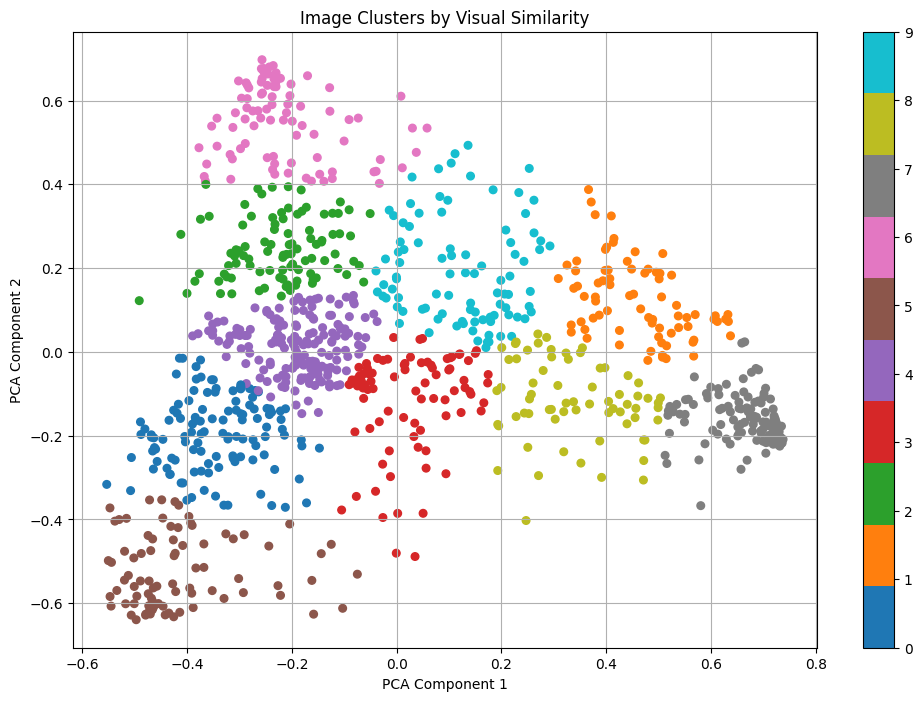

In [13]:
'''
EDA Plot: Cluster Images by Visual Similarity
'''

def extract_features(img_path):
    #read the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #resize to small for faster processing
    img = cv2.resize(img, (64, 64))
    hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

#extract features from a random sample of images
sample_files = random.sample(image_filenames, 1000)
features = []

for filename in sample_files:
    img_path = os.path.join(images_path, filename)
    feature = extract_features(img_path)
    features.append(feature)

features = np.array(features)

#dimensionality reduction: PCA to 2D
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

#clustering using KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(features_pca)

#plot the clusters
plt.figure(figsize=(12, 8))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters, cmap='tab10', s=30)
plt.title("Image Clusters by Visual Similarity")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar()
plt.grid(True)
#save output data
plt.savefig("outputs/eda/image_clusters_by_visual_similarity.png", bbox_inches="tight")
plt.show()

## Defining Keywords for List of Moods

In [10]:
#define mood keywords
mood_keywords = {
    "Cozy": ["cozy", "warm", "comfortable", "blanket", "fireplace", "pillow", "bed", "relax", "fuzzy", "soft", "glow", "hygge", "snug"],
    "Dreamy": ["dreamy", "fantasy", "whimsical", "cloud", "ethereal", "soft focus", "float", "gentle", "aura", "celestial"],
    "Romantic": ["romantic", "love", "passion", "heart", "date", "candle", "affection", "valentine", "couple", "roses"],
    "Minimalist": ["minimalist", "simple", "clean", "neutral", "decluttered", "white space", "zen", "scandinavian", "sleek"],
    "Vibrant": ["vibrant", "colorful", "bright", "neon", "pop", "saturated", "bold", "eye-catching", "electric"],
    "Vintage": ["vintage", "old", "retro", "nostalgic", "film", "grainy", "sepia", "analog", "classic", "timeless"],
    "Natural": ["natural", "outdoors", "nature", "earthy", "organic", "forest", "greenery", "sunlight", "flora", "rustic"],
    "Adventurous": ["adventurous", "explore", "travel", "hike", "camp", "wanderlust", "road trip", "journey", "trail", "expedition"]
}

#define color keywords
color_keywords = {
    "Pink": ["pink", "rose", "blush", "baby pink", "pastel pink", "fuchsia", "magenta", "hot pink"],
    "Red": ["red", "crimson", "scarlet", "cherry", "maroon", "ruby", "wine"],
    "Orange": ["orange", "tangerine", "peach", "amber", "coral", "apricot", "burnt orange"],
    "Yellow": ["yellow", "gold", "sunshine", "lemon", "butter", "mustard", "daisy"],
    "Green": ["green", "emerald", "forest", "mint", "sage", "olive", "lime", "moss"],
    "Blue": ["blue", "azure", "navy", "sky", "aqua", "teal", "indigo", "cobalt", "baby blue"],
    "Purple": ["purple", "lavender", "violet", "plum", "lilac", "mauve", "orchid", "amethyst"],
    "White": ["white", "ivory", "pearl", "cream", "off-white", "snow", "vanilla"]
}

## Category Mapping for Automatic Tags

In [11]:
#load the full CSV
df = pd.read_csv("data/filtered_mood_color_dataset.csv")

all_tags = df['tags'].explode().dropna()
tag_counts = Counter(all_tags)
print(f"Total unique tags: {len(tag_counts)}")

for tag, count in tag_counts.most_common(200):
    print(f"{tag}: {count}")

tag_to_mood = {
    "blanket": "Cozy",
    "glow": "Dreamy",
    "couple": "Romantic",
    "white space": "Minimalist",
    "bright": "Vibrant",
    "retro": "Vintage",
    "forest": "Natural",
    "explore": "Adventurous",
}

def get_mood_from_tags(tags):
    for tag in tags:
        if tag in tag_to_mood:
            return tag_to_mood[tag]
    return None

df["auto_mood"] = df["tags"].apply(get_mood_from_tags)


Total unique tags: 7309
['beautiful', 'beauty', 'blaze of color', 'bloom', 'blooming', 'blossom', 'bokeh', 'bright', 'brown', 'bunch', 'color', 'colorful', 'colors', 'colour', 'countryside', 'easter', 'fantasy', 'flora', 'florescence', 'flower', 'flowers', 'flush', 'forest', 'fresh', 'garden', 'gaudy', 'gorgeous', 'grass', 'green', 'ground', 'growth', 'leaf', 'light', 'macro', 'magenta', 'natural', 'outdoors', 'park', 'petal', 'petals', 'plant', 'red', 'relax', 'rich coloring', 'scenery', 'season', 'space', 'spring', 'summer', 'swirley', 'swirly', 'warm', 'wild', 'wilderness', 'yellow']: 22
['architectural design', 'architecture', 'blue', 'blue background', 'blue sky', 'blue wallpaper', 'colorful', 'colorful background', 'colorful houses', 'colorful wallpaper', 'daylight', 'design', 'exterior', 'facade', 'green', 'houses', 'outdoors', 'perspective', 'pink', 'roof', 'simple', 'simple background', 'simple wallpaper', 'simplicity', 'sky', 'travel', 'wood', 'yellow']: 16
['beautiful', 'bea

## Python Script to Reduce Dataset from 110k to ~10K Images

In [12]:
#load the JSON file from the dataset
with open("data/pexels-110k-512p-min-jpg/attributes_df.json", "r") as f:
    attributes = json.load(f)

#flip outer and inner keys
flipped = {}
for field, image_dict in attributes.items():
    for image_id, value in image_dict.items():
        if image_id not in flipped:
            flipped[image_id] = {}
        flipped[image_id][field] = value

#convert to Dataframe
df = pd.DataFrame.from_dict(flipped, orient="index").reset_index()
df.rename(columns={"index": "image_id"}, inplace=True)

first_key = list(attributes.keys())[0]
print(f"First image ID: {first_key}")
print("Keys inside first image:", attributes[first_key].keys())

print("Columns:", df.columns.tolist())
print(df[['image_id', 'tags']].head())

#convert to list if needed
df['tags'] = df['tags'].apply(lambda x: x if isinstance(x, list) else[])


First image ID: title
Keys inside first image: dict_keys(['3186010', '3185509', '3182800', '3184308', '3185747', '3185751', '3184419', '3183136', '3184404', '3185495', '3185753', '3185490', '3185538', '3185482', '3183141', '3184289', '3184463', '3184455', '3184304', '3183143', '3184465', '3184464', '3184407', '3184656', '3183144', '3185746', '3184408', '3184461', '3184462', '3184468', '3184285', '3184435', '3183131', '3183135', '3184437', '3186325', '3183132', '3184165', '3184166', '3186321', '3184167', '3183130', '3184159', '3183194', '3182780', '3184657', '3183824', '3184642', '3184161', '3184168', '3184313', '3182793', '3183199', '3184426', '3184307', '3183184', '3184645', '3184309', '3184481', '3182530', '3183187', '3182782', '3184641', '3183163', '3183164', '3184658', '3184639', '3185041', '3182783', '3182781', '3183176', '3184960', '3183190', '3182778', '3182799', '3183186', '3184663', '3184660', '3184731', '3184664', '3183125', '3182797', '3183188', '3183156', '3183183', '318319

In [13]:
def match_keywords(tag_list, keywords):
    return any(kw in tag_list for kw in keywords)

#filter by mood
filtered_data = defaultdict(list)

for mood, mood_words in mood_keywords.items():
    for color, color_words in color_keywords.items():
        subset = df[df['tags'].apply(
            lambda tags: match_keywords(tags, mood_words) and match_keywords(tags, color_words)
        )].copy()


        #adjust sample side if needed
        #sampled = subset.sample(n=min(500, len(subset)), random_state=42)
        sampled = subset

        print(f"{mood}_{color}: {len(subset)} total, using {len(sampled)} samples")
        sampled.loc[:, "mood"] = mood
        sampled.loc[:, "color_theme"] = color
        filtered_data[f"{mood}_{color}"] = sampled

#combine all filtered data into one dataset
final_df = pd.concat(filtered_data.values(), ignore_index=True)

#preview
print("Final filtered dataset shape:", final_df.shape)
print(final_df[['image_id', 'mood', 'color_theme', 'tags']].head())

#save to CSV
final_df.to_csv("data/filtered_mood_color_dataset.csv", index=False)

Cozy_Pink: 24 total, using 24 samples
Cozy_Red: 43 total, using 43 samples
Cozy_Orange: 17 total, using 17 samples
Cozy_Yellow: 23 total, using 23 samples
Cozy_Green: 38 total, using 38 samples
Cozy_Blue: 73 total, using 73 samples
Cozy_Purple: 11 total, using 11 samples
Cozy_White: 61 total, using 61 samples
Dreamy_Pink: 9 total, using 9 samples
Dreamy_Red: 4 total, using 4 samples
Dreamy_Orange: 4 total, using 4 samples
Dreamy_Yellow: 15 total, using 15 samples
Dreamy_Green: 30 total, using 30 samples
Dreamy_Blue: 182 total, using 182 samples
Dreamy_Purple: 3 total, using 3 samples
Dreamy_White: 35 total, using 35 samples
Romantic_Pink: 188 total, using 188 samples
Romantic_Red: 140 total, using 140 samples
Romantic_Orange: 13 total, using 13 samples
Romantic_Yellow: 62 total, using 62 samples
Romantic_Green: 88 total, using 88 samples
Romantic_Blue: 170 total, using 170 samples
Romantic_Purple: 29 total, using 29 samples
Romantic_White: 125 total, using 125 samples
Minimalist_Pink: 

In [15]:
# Step 1: Load CSV
df = pd.read_csv("data/filtered_mood_color_dataset.csv")

# Step 2: Count image files in folder
image_folder = "data/filtered_images"
image_files = {os.path.splitext(f)[0] for f in os.listdir(image_folder) if f.endswith(".jpg")}

# Step 3: Count how many image IDs in CSV actually exist as image files
csv_image_ids = set(df["image_id"].astype(str))
valid_ids = csv_image_ids & image_files

print(f"Total image files in folder: {len(image_files)}")
print(f"Total entries in CSV: {len(df)}")
print(f"Matched image_id entries: {len(valid_ids)}")
print(f"Missing image_id entries in folder: {len(csv_image_ids - image_files)}")

📊 Total image files in folder: 19608
📄 Total entries in CSV: 39499
✅ Matched image_id entries: 7328
❌ Missing image_id entries in folder: 16175


In [17]:
# Step 1: Load the original big CSV
df = pd.read_csv("data/filtered_mood_color_dataset.csv")

# Step 2: Create set of existing image filenames
image_folder = "data/filtered_images"
image_ids_present = {os.path.splitext(f)[0] for f in os.listdir(image_folder) if f.endswith(".jpg")}

# Step 3: Filter DataFrame to only keep rows with existing images
df_filtered = df[df["image_id"].astype(str).isin(image_ids_present)]

# Step 4: Save new filtered CSV
df_filtered.to_csv("data/filtered_mood_color_dataset.csv", index=False)
print(f"New filtered CSV saved with {len(df_filtered)} valid entries.")

✅ New filtered CSV saved with 12624 valid entries.


In [18]:
# Reload new filtered CSV
df_new = pd.read_csv("data/filtered_mood_color_dataset.csv")

# Check for nulls in the mood column
num_with_mood = df_new["mood"].notna().sum()
print(f"Entries with mood labels: {num_with_mood}")
print(f"Missing mood labels: {len(df_new) - num_with_mood}")


✅ Entries with mood labels: 12624
❌ Missing mood labels: 0


In [19]:
df = pd.read_csv("data/filtered_mood_color_dataset.csv")

# Check mood labels
print("Total entries:", len(df))
print("Entries with non-null mood:", df["mood"].notna().sum())

Total entries: 12624
Entries with non-null mood: 12624


## Copy Matching Image Files

In [14]:
"""image_root = "data/pexels-110k-512p-min-jpg/images"
output_root = "data/filtered_images"

missing = 0

#loop with full rows to get mood & color
for _, row in tqdm(final_df.iterrows(), total=len(final_df)):
    image_id = str(row['image_id'])
    mood = row['mood']
    color = row['color_theme']

    #construct source path
    src = os.path.join(image_root, f"{image_id}.jpg")

    #construction destination path
    dst_dir = os.path.join('data/filtered_images')
    dst = os.path.join(dst_dir, f"{image_id}.jpg")

    #create destination folder if it doesn't exist
    os.makedirs(dst_dir, exist_ok=True)

    #only copy if source file exists
    if os.path.exists(src):
        shutil.copy(src, dst)
    else:
        missing += 1

print(f"Total Missing Images: {missing}")"""

image_root = "data/pexels-110k-512p-min-jpg/images"
output_root = "data/filtered_images"
os.makedirs(output_root, exist_ok=True)

missing = 0
copied = 0

# Track label combo counts
combo_counter = Counter()

for _, row in tqdm(final_df.iterrows(), total=len(final_df)):
    image_id = str(row['image_id'])
    mood = row['mood']
    color = row['color_theme']
    combo_counter[f"{mood}_{color}"] += 1

    src = os.path.join(image_root, f"{image_id}.jpg")
    dst = os.path.join(output_root, f"{image_id}.jpg")

    if os.path.exists(src):
        shutil.copy(src, dst)
        copied += 1
    else:
        print(f"Missing image: {src}")
        missing += 1

print(f"\nCopied: {copied} images")
print(f"Missing: {missing} images")
print("\nSample count per mood_color combo:")
for combo, count in combo_counter.items():
    print(f"  {combo}: {count}")


  0%|          | 156/39499 [00:00<00:47, 820.49it/s]

Missing image: data/pexels-110k-512p-min-jpg/images/2857583.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2318068.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2261128.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1660192.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/696179.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1059054.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1046639.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1045040.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/928060.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/929778.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3036525.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3019019.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2726986.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2686392.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2261128.jpg
Missing image: data/pexels-110k-512p-min-jp

  1%|          | 475/39499 [00:00<00:28, 1373.77it/s]

Missing image: data/pexels-110k-512p-min-jpg/images/2549944.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1743229.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1743231.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1493211.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1083936.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/696179.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2852454.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2813280.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2705740.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2549224.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2458393.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2422700.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2270969.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2140972.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1937336.jpg
Missing image: data/pexels-110k-512p-min-

  2%|▏         | 841/39499 [00:00<00:25, 1488.27it/s]

Missing image: data/pexels-110k-512p-min-jpg/images/2404007.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2378810.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2365457.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2267850.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2182040.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2086620.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2097628.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1933315.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1693095.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1431822.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1403550.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1367179.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1227513.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1178784.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1056528.jpg
Missing image: data/pexels-110k-512p-min

  3%|▎         | 1208/39499 [00:00<00:22, 1671.29it/s]

Missing image: data/pexels-110k-512p-min-jpg/images/2386832.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1917358.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1765496.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2791043.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2791004.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1210001.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1210273.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1021068.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1021075.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3036525.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2983462.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2957497.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2917357.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2826326.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2306278.jpg
Missing image: data/pexels-110k-512p-min

  4%|▍         | 1640/39499 [00:01<00:19, 1919.63it/s]

Missing image: data/pexels-110k-512p-min-jpg/images/2802429.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2131978.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1439871.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1121603.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1036443.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3041112.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2904142.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2679542.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2512281.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1228514.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1251083.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1172851.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1013329.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1018137.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1007025.jpg
Missing image: data/pexels-110k-512p-min

  5%|▌         | 2139/39499 [00:01<00:17, 2157.34it/s]

Missing image: data/pexels-110k-512p-min-jpg/images/3013120.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2530915.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2343532.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2305188.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2088170.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2067048.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1486844.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1301979.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1187080.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1121603.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1064760.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1029036.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1025322.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/943714.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2067509.jpg
Missing image: data/pexels-110k-512p-min-

  7%|▋         | 2750/39499 [00:01<00:15, 2378.32it/s]

Missing image: data/pexels-110k-512p-min-jpg/images/2091109.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1927215.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1726783.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1603606.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1486844.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1458377.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1064760.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1036432.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/953782.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/936801.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3004519.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2952867.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2951525.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2883203.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2794711.jpg
Missing image: data/pexels-110k-512p-min-j

 10%|▉         | 3754/39499 [00:01<00:12, 2879.99it/s]

Missing image: data/pexels-110k-512p-min-jpg/images/2923003.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2892244.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2769274.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2703907.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2704048.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2549050.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2061170.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1672333.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1659689.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1586701.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1486844.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1458243.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1260747.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1161547.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1125943.jpg
Missing image: data/pexels-110k-512p-min

 12%|█▏        | 4726/39499 [00:02<00:12, 2710.83it/s]

Missing image: data/pexels-110k-512p-min-jpg/images/3024530.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2922413.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2918149.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2832076.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2760612.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2741479.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2704048.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2679224.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2563854.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2561382.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2437681.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2481603.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2437288.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2383360.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2304425.jpg
Missing image: data/pexels-110k-512p-min

 14%|█▎        | 5421/39499 [00:02<00:14, 2298.84it/s]

Missing image: data/pexels-110k-512p-min-jpg/images/3024530.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3013120.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2964778.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2922413.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2903375.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2745581.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2679224.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2548532.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2537112.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2472269.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2249958.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2129773.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1685236.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1581363.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1436129.jpg
Missing image: data/pexels-110k-512p-min

 15%|█▌        | 5991/39499 [00:02<00:14, 2297.61it/s]

Missing image: data/pexels-110k-512p-min-jpg/images/2263062.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2115695.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2132207.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1995842.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1761362.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1694429.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1708842.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1701403.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1666008.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1579255.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1557183.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1441998.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1410013.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1376276.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1179970.jpg
Missing image: data/pexels-110k-512p-min

 16%|█▌        | 6387/39499 [00:03<00:12, 2670.76it/s]

Missing image: data/pexels-110k-512p-min-jpg/images/1809336.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1805401.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1773349.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1765417.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1762928.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1727414.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1729196.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1693443.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1713953.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1713948.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1713951.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1707684.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1713950.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1702622.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1701398.jpg
Missing image: data/pexels-110k-512p-min

 18%|█▊        | 7152/39499 [00:03<00:10, 3137.14it/s]

Missing image: data/pexels-110k-512p-min-jpg/images/2868966.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2859334.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2836735.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2854744.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2851064.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2847939.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2771409.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2771414.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2479234.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2828642.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2821944.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2820143.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2820142.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2814310.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2814198.jpg
Missing image: data/pexels-110k-512p-min

 21%|██        | 8182/39499 [00:03<00:08, 3623.60it/s]

Missing image: data/pexels-110k-512p-min-jpg/images/2923034.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2971061.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2775184.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2739908.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2709565.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2673876.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2530915.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2386832.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2377965.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2187300.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2170498.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2091109.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2071718.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2042563.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1927215.jpg
Missing image: data/pexels-110k-512p-min

 22%|██▏       | 8594/39499 [00:03<00:14, 2153.61it/s]

Missing image: data/pexels-110k-512p-min-jpg/images/3013966.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3013820.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2923003.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2892244.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2819553.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2814800.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2809256.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2704048.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2178795.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2061170.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1838853.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1821683.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1659689.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1586701.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1571087.jpg
Missing image: data/pexels-110k-512p-min

 27%|██▋       | 10724/39499 [00:04<00:05, 5358.14it/s]

Missing image: data/pexels-110k-512p-min-jpg/images/3051609.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3049400.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3059784.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3051896.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3051895.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3051644.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3051306.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3060703.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3063174.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3060359.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3055014.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3055021.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3055015.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3055025.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3054863.jpg
Missing image: data/pexels-110k-512p-min

 32%|███▏      | 12728/39499 [00:04<00:03, 8541.23it/s]

Missing image: data/pexels-110k-512p-min-jpg/images/1134076.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1129420.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1129418.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1129417.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1129421.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1128123.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1128121.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1127032.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1125272.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1125793.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1125776.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1125278.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1125265.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1125262.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1125778.jpg
Missing image: data/pexels-110k-512p-min

 39%|███▊      | 15301/39499 [00:06<00:15, 1552.71it/s]

Missing image: data/pexels-110k-512p-min-jpg/images/3045699.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3036240.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3025880.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3024530.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3013966.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3021130.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3013960.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2906050.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2745258.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2929906.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2929268.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2922413.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2918149.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2912717.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2909230.jpg
Missing image: data/pexels-110k-512p-min

 45%|████▌     | 17911/39499 [00:07<00:07, 2827.90it/s]

Missing image: data/pexels-110k-512p-min-jpg/images/3061171.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3061594.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3059137.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3061596.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3061442.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3054423.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3059129.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3057960.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3065595.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3063061.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3062228.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3049806.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3051551.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3059109.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3058828.jpg
Missing image: data/pexels-110k-512p-min

 57%|█████▋    | 22430/39499 [00:07<00:02, 6680.02it/s]

Missing image: data/pexels-110k-512p-min-jpg/images/1794858.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1793525.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1787432.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1765092.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1789489.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1770801.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1761069.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1763479.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1785622.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1785687.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1785420.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1785000.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1785001.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1784679.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1784754.jpg
Missing image: data/pexels-110k-512p-min

 71%|███████   | 27914/39499 [00:11<00:07, 1581.33it/s]

Missing image: data/pexels-110k-512p-min-jpg/images/3056570.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3049340.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3029868.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3038324.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3024530.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3013820.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3016479.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2996305.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3013120.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3008509.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3027782.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2975684.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2389473.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2988035.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2984598.jpg
Missing image: data/pexels-110k-512p-min

 77%|███████▋  | 30489/39499 [00:12<00:02, 4284.30it/s]

Missing image: data/pexels-110k-512p-min-jpg/images/2575758.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1567736.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1435550.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1431176.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1431193.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1412146.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1170586.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1109580.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1107898.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1082067.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/1064760.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3051573.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3062964.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3054312.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3054152.jpg
Missing image: data/pexels-110k-512p-min

 81%|████████  | 31799/39499 [00:13<00:03, 2166.13it/s]

Missing image: data/pexels-110k-512p-min-jpg/images/3008509.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2971061.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2745258.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2928071.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2899221.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2892588.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2893900.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2887795.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2870346.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2827948.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2812841.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2662086.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2563082.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2440022.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2440024.jpg
Missing image: data/pexels-110k-512p-min

 84%|████████▍ | 33289/39499 [00:13<00:01, 3439.44it/s]

Missing image: data/pexels-110k-512p-min-jpg/images/2894873.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2893479.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2889384.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2890344.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2888958.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2888100.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2888106.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2888101.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2888108.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2888102.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2887160.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2886475.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2886213.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2885216.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2893768.jpg
Missing image: data/pexels-110k-512p-min

 93%|█████████▎| 36537/39499 [00:13<00:00, 5903.50it/s]

Missing image: data/pexels-110k-512p-min-jpg/images/3036240.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3025880.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3021130.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2745258.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2929906.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2929268.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2912717.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2887795.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2888098.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2883832.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2904640.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2873624.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2900783.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2867014.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2789094.jpg
Missing image: data/pexels-110k-512p-min

 99%|█████████▉| 39274/39499 [00:15<00:00, 3079.54it/s]

Missing image: data/pexels-110k-512p-min-jpg/images/3038324.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3013820.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2996305.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/3013120.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2975684.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2389473.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2988035.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2962004.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2945692.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2946816.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2961993.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2745258.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2946349.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2932353.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2898315.jpg
Missing image: data/pexels-110k-512p-min

100%|██████████| 39499/39499 [00:15<00:00, 2550.05it/s]

Missing image: data/pexels-110k-512p-min-jpg/images/2745258.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2928071.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2892588.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2893900.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2887795.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2870346.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2834934.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2668461.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2662086.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2414250.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2403402.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2403278.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2333866.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2314981.jpg
Missing image: data/pexels-110k-512p-min-jpg/images/2076968.jpg
Missing image: data/pexels-110k-512p-min